# Model selection for predicting `IN_LEAGUE_NEXT`

In this notebook we perform model selection with the goal of generating the best classifier for the response variable `IN_LEAGUE_NEXT`, whether or not a given player will play at any point in the next NBA season (and thus have stats data).

We will do all model selection using _only_ the set of training data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

## Load the data

_Note:_ we don't have `IN_LEAGUE_NEXT` data for the 2023 season (because we still don't know if a given player will play _at any point_ in the 2024 season).  As a result, we have to restrict our data to `SEASON_START` before 2023.

In [2]:
#load the data
df_train = pd.read_csv("Data/merged_data/train_data.csv")

#NOTE: we don't have IN_LEAGUE_NEXT data for SEASON_START = 2023 and drop nan rows
df_train = df_train[df_train.SEASON_START < 2023].dropna()

## Correlations

Now we'll look at correlations between the predictors and the response variable.  Below we grab the numeric columns and make a correlation heatmap before printing the correlations with `IN_LEAGUE_NEXT`.

In [3]:
#grab all columns
all_cols = list(df_train.columns)

#grab just the columns with numeric data
num_cols = [all_cols[2]] + all_cols[4:6] + all_cols[7:]

#grab just the predictors for later
predictors = num_cols[:-1]

IN_LEAGUE_NEXT    1.000000
GP                0.462373
MIN               0.427752
PF                0.425080
WAIVED            0.383255
FGM               0.372937
FGA               0.372071
PTS               0.368640
TOV               0.359772
DREB              0.357740
REB               0.353179
STL               0.352597
DWS               0.346434
WAIVED_REG        0.345849
WS                0.335903
Name: IN_LEAGUE_NEXT, dtype: float64

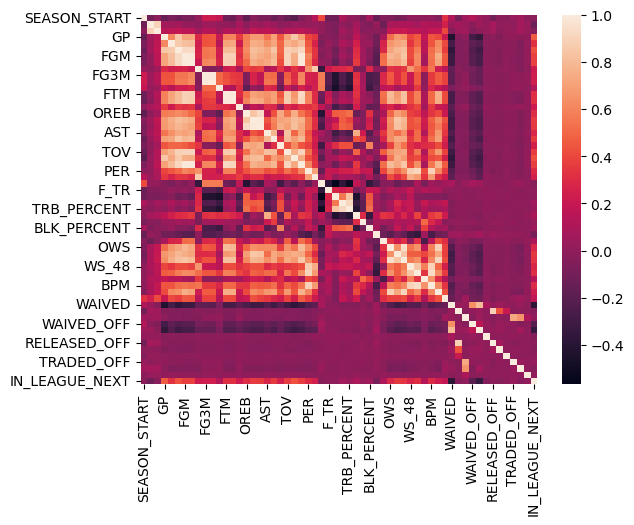

In [4]:
#compute correlations between numeric data columns
corr = df_train[num_cols].corr()

#plot heatmap
sns.heatmap(corr)

#print top 15 or so |correlations| with IN_LEAGUE_NEXT in descending order
abs(corr["IN_LEAGUE_NEXT"]).sort_values(ascending=False)[0:15]

# Modeling

## Model 1: Naive logistic regression model

Let's begin by finding the 5-fold CV performance of a simple logistic regression model on the training set.

The primary metric we'll use to score the model's performance is the _balanced accuracy score_ (https://scikit-learn.org/dev/modules/model_evaluation.html#balanced-accuracy-score), which generalizes the accuracy score to imbalanced classes (which is the case here; see the cell immediately below).

In [5]:
#show that we have imbalanced classes
df_train.IN_LEAGUE_NEXT.value_counts(normalize=False)

IN_LEAGUE_NEXT
1.0    9575
0.0    2078
Name: count, dtype: int64

In [6]:
#import the functions we need for modeling
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import balanced_accuracy_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [7]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=815)

bal_acc_scores = [] #store a balanced accuracy score for each of the folds

for i, (train_idx, test_idx) in enumerate(kfold.split(df_train[predictors], df_train.IN_LEAGUE_NEXT)):
    #grab the raw training data and test data for this CV fold
    X_tt  = df_train[predictors].iloc[train_idx]
    y_tt  = df_train.IN_LEAGUE_NEXT.iloc[train_idx]
    X_val = df_train[predictors].iloc[test_idx]
    y_val = df_train.IN_LEAGUE_NEXT.iloc[test_idx]

    #train the model
    lr = Pipeline([("scale", StandardScaler()), ("log-reg", LogisticRegression(penalty=None, max_iter=10_000))])
    lr.fit(X_tt, y_tt)

    #get prediction on training data, compute balanced accuracy
    pred_train    = lr.predict(X_tt)
    bal_acc_train = balanced_accuracy_score(y_tt, pred_train)
    
    #get prediction and balanced accuracy scores for validation set
    pred_val    = lr.predict(X_val)
    bal_acc_val = balanced_accuracy_score(y_val, pred_val)
    bal_acc_scores.append(bal_acc_val)

    print(f"CV fold {i} train acc: {bal_acc_train:.3f}, val acc: {bal_acc_val:.3f}")

print("\n" + f"Naive LR average bal. acc. score: {np.mean(bal_acc_scores):.3f}")

CV fold 0 train acc: 0.705, val acc: 0.680
CV fold 1 train acc: 0.698, val acc: 0.704
CV fold 2 train acc: 0.698, val acc: 0.712
CV fold 3 train acc: 0.708, val acc: 0.693
CV fold 4 train acc: 0.697, val acc: 0.705

Naive LR average bal. acc. score: 0.699


## Model 2: Logistic regression model trained on balanced classes

We'll now address the fact that our classes are imbalanced by augmenting the training data used in each CV fold.  To do so, we'll use the `imblearn` library's data augmentation functions.  Of these functions, I find that the Synthetic Minority Oversampling Technique (SMOTE) gives the best performance.

In [8]:
#import SMOTE
from imblearn.over_sampling import SMOTE

In [10]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=815)

bal_acc_scores = [] #store a balanced accuracy score for each of the folds

for i, (train_idx, test_idx) in enumerate(kfold.split(df_train[predictors], df_train.IN_LEAGUE_NEXT)):
    #grab the raw training data and test data for this CV fold
    X_tt  = df_train[predictors].iloc[train_idx]
    y_tt  = df_train.IN_LEAGUE_NEXT.iloc[train_idx]
    X_val = df_train[predictors].iloc[test_idx]
    y_val = df_train.IN_LEAGUE_NEXT.iloc[test_idx]

    #resample the training data using SMOTE
    smote = SMOTE(random_state=5)
    X_tt_re, y_tt_re = smote.fit_resample(X_tt, y_tt)

    #train the model
    lr = Pipeline([("scale", StandardScaler()), ("log-reg", LogisticRegression(penalty=None, max_iter=10_000))])
    lr.fit(X_tt_re, y_tt_re)

    #get prediction, compute balanced accuracy on non-resampled training data
    pred_train    = lr.predict(X_tt)
    bal_acc_train = balanced_accuracy_score(y_tt, pred_train)
    
    #get prediction and balanced accuracy scores for validation set
    pred_val    = lr.predict(X_val)
    bal_acc_val = balanced_accuracy_score(y_val, pred_val)
    bal_acc_scores.append(bal_acc_val)

    print(f"CV fold {i} train acc: {bal_acc_train:.3f}, val acc: {bal_acc_val:.3f}")

print("\n" + f"SMOTE LR average bal. acc. score: {np.mean(bal_acc_scores):.3f}")

CV fold 0 train acc: 0.773, val acc: 0.777
CV fold 1 train acc: 0.791, val acc: 0.759
CV fold 2 train acc: 0.779, val acc: 0.772
CV fold 3 train acc: 0.770, val acc: 0.759
CV fold 4 train acc: 0.772, val acc: 0.794

SMOTE LR average bal. acc. score: 0.772


### SMOTE-balanced training data gives improved performance.

Notice that the performance is about 10% better in terms of the balanced accuracy score, simply by training the model with a set of augmented data (from SMOTE).

## Model 3: KNN

The previous models seem to be getting balanced accuracy scores up to about 77%.  It doesn't seem like we're overfitting the training data, because our training accuracy is approximately equal to the validation set accuracy for each CV fold.  One possibility is that the logistic regression model is too inflexible; for this reason, next we'll try a KNN classifier.